# 2 梯度提升树
`class xgboost.XGBRegressor (max_depth=3, learning_rate=0.1, n_estimators=100, silent=True,objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0,subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,base_score=0.5, random_state=0, seed=None, missing=None, importance_type='gain', **kwargs)`
## 2.1 提升集成算法：重要参数n_estimators
XGBoost的基础是梯度提升算法。梯度提升（Gradient boosting）是构建预测模型的最强大技术之一，它是集成算法中提升法（Boosting）的代表算法。**集成算法通过在数据上构建多个弱评估器，汇总所有弱评估器的建模结果，以获取比单个模型更好的回归或分类表现**。弱评估器被定义为是表现至少比随机猜测更好的模型，即预测准确率不低于50%的任意模型。

以梯度提升回归树为例子，来了解一下Boosting算法是怎样工作的。

首先，梯度提升回归树是专注于回归的树模型的提升集成模型，其建模过程大致如下：最开始先建立一棵树，然后逐渐迭代，每次迭代过程中都增加一棵树，逐渐形成众多树模型集成的强评估器。
对于梯度提升回归树来说，每个样本的预测结果可以表示为所有树上的结果的加权求和：
$$ \hat{y}_i^{(k)} = \sum_{k=1}^K \gamma_k*h_k(x_i)$$
其中，$K$是树的总数量，$k$代表第$k$棵树，$\gamma_k$是这棵树的权重，$h_k(x_i)$表示这棵树上的预测结果。

而XGB作为GBDT的改进，在$\hat{y}$上却有所不同。对于XGB来说，每个叶子节点上会有一个预测分数（prediction score），也被称为叶子权重。**这个叶子权重就是所有在这个叶子节点上的样本在这一棵树上的回归取值，用$f_k(x_i)$或者$w$来表示**，其中$f_k$表示第$k$棵决策树，$x_i$表示样本$i$对应的特征向量。当只有一棵树的时候，$f_1(x_i)$就是提升集成算法返回的结果，但这个结果往往非常糟糕。当有多棵树的时候，集成模型的回归结果就是所有树的预测分数之和，假设这个集成模型中总共有$K$棵决策树，则整个模型在这个样本上给出的预测结果为：
$$ \hat{y}_i^{(k)} = \sum_{k=1}^K f_k(x_i)$$

### 截图
从上面的式子来看，在集成中我们需要的考虑的第一件事是我们的超参数$K$，究竟建多少棵树比较合适呢？
### 截图
先来进行一次简单的建模：

1. **导入需要的库，模块以及数据**

In [1]:
from xgboost import XGBRegressor as XGBR  # sklearn的模块
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime

data = load_boston()
# 波士顿房价数据集非常简单，但所涉及的问题却很多

X = data.data  # (506,13)
y = data.target  # (506,)

D:\ANACONDA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func

2. **建模，查看相关接口和属性**

In [2]:
Xtrain, Xtest, Ytrain, Ytest = TTS(X, y, test_size=0.3, random_state=420)

reg = XGBR(n_estimators=100).fit(Xtrain, Ytrain)
reg.predict(Xtest)  # 传统接口predict：给定输入，返回输出预测结果
reg.score(Xtest, Ytest)  # 0.9051 传统接口score：给定输入输出，返回R^2
MSE(Ytest, reg.predict(Xtest))  # 8.831

reg.feature_importances_
# 树模型的优势之一：能够查看模型的重要性分数，可以使用嵌入法(SelectFromModel)进行特征选择

array([0.01902169, 0.00421091, 0.01478316, 0.00553537, 0.02222194,
       0.37914085, 0.01679687, 0.04698726, 0.0407358 , 0.05491744,
       0.06684238, 0.00869463, 0.32011172], dtype=float32)

3. **交叉验证，与线性回归&随机森林回归进行对比**

In [3]:
reg = XGBR(n_estimators=100)
print(CVS(reg, Xtrain, Ytrain, cv=5).mean())  # 返回R^2：0.7995
# 这里返回什么模型评估指标，取决于reg.score()中的score是什么
# 对于分类模型来说，score默认返回的是准确率，而对于回归模型来说，默认返回的是R^2

0.7995062821902295


题外话：**交叉验证应该只使用训练集数据**。==交叉验证的目的是评估训练模型的泛化能力==，即在未见过的数据上的表现，因此只应该使用训练集数据来评估模型的性能。若用所有数据用于训练和评估会导致模型对数据过拟合并且无法在未知数据上进行验证，因此会导致对模型性能的错误估计。

In [4]:
# 查看一下sklearn中都有哪些模型评估指标
import sklearn

print(sorted(sklearn.metrics.SCORERS.keys()))

# 可以用负MSE作为评估指标：越接近0越好
print(CVS(reg, Xtrain, Ytrain, cv=5, scoring='neg_mean_squared_error').mean())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 

In [5]:
# 与随机森林和线性回归进行对比
rfr = RFR(n_estimators=100)
print(CVS(rfr, Xtrain, Ytrain, cv=5).mean())
print(CVS(rfr, Xtrain, Ytrain, cv=5, scoring='neg_mean_squared_error').mean())

lr = LinearR()
print(CVS(lr, Xtrain, Ytrain, cv=5).mean())
print(CVS(lr, Xtrain, Ytrain, cv=5, scoring='neg_mean_squared_error').mean())
# 可以看出，XGBR跟随机森林的效果相差不大，但都比线性回归要好

0.8034879519452829
-16.94479015657948
0.6835070597278083
-25.34950749364842


In [6]:
# 设置参数verbosity为1或更大的值：在数据巨大，预料到算法运行会非常缓慢的时候可以使用这个参数来监控模型的训练进度
reg = XGBR(n_estimators=10, verbosity=2)
CVS(reg, Xtrain, Ytrain, cv=5, scoring='neg_mean_squared_error').mean()

[10:55:21] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=4
[10:55:21] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[10:55:21] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[10:55:21] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[10:55:21] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1

-18.633733952333067

4. **定义绘制以训练样本数为横坐标的学习曲线的函数**

In [7]:
def plot_learning_curve(estimator, title, X, y,
                        ax=None,  #选择子图
                        ylim=None,  #设置纵坐标的取值范围
                        cv=None,  #交叉验证
                        n_jobs=None  #设定索要使用的线程
                        ):
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y
                                                            , shuffle=True
                                                            , cv=cv
                                                            , random_state=420
                                                            , n_jobs=n_jobs)
    if ax is None:
        ax = plt.gca()
    else:
        ax = plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.grid()  #绘制网格，不是必须
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g", label="Test score")
    ax.legend(loc="best")
    return ax

5. **使用学习曲线观察XGB在波士顿房价数据集上的潜力**

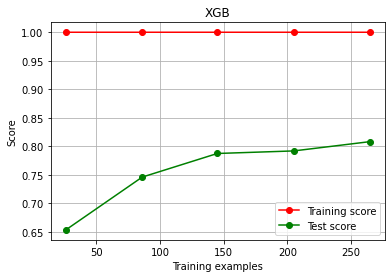

In [8]:
cv = KFold(n_splits=4, shuffle=True, random_state=42)
plot_learning_curve(XGBR(n_estimators=100, random_state=420)
                    , "XGB", Xtrain, Ytrain, ax=None, cv=cv)
plt.show()
# 过拟合了。在现在的状况下，如何看数据的潜力？还能调上去么？

6. **使用参数学习曲线观察n_estimators对模型的影响**

210 0.8079543174426773


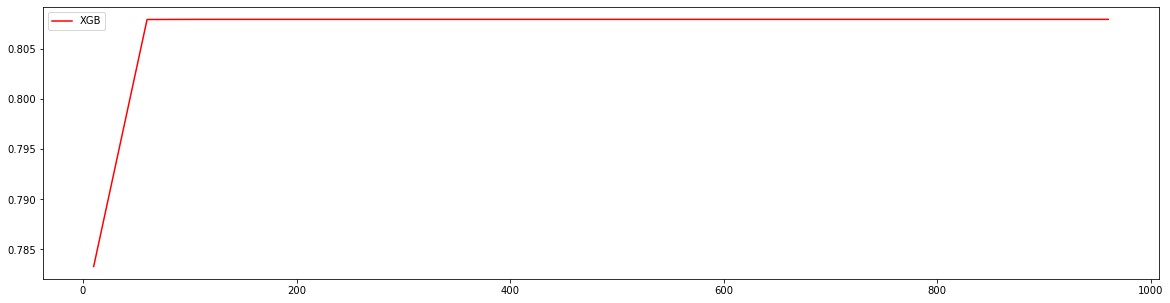

In [9]:
axisx = range(10, 1010, 50)
rs = []
for i in axisx:
    reg = XGBR(n_estimators=i, random_state=420)
    rs.append(CVS(reg, Xtrain, Ytrain, cv=cv).mean())
print(axisx[rs.index(max(rs))], max(rs))
plt.figure(figsize=(20, 5))
plt.plot(axisx, rs, c="red", label="XGB")
plt.legend()
plt.show()

# 我们是否就要选择准确率最高的n_estimators值呢？

7. **进化的学习曲线：方差与泛化误差**

在机器学习中，用来衡量模型在未知数据上的准确率的指标，叫做**泛化误差**（Genelization error）。一个集成模型(f)在未知数据集(D)上的泛化误差$E(f;D)$，由方差(var)，偏差(bais)和噪声(ε)共同决定。其中偏差由训练集上的拟合程度决定，方差由模型的稳定性决定，噪音是不可控的。**而泛化误差越小，模型就越理想**。
$$E(f;D) = var + bias^2 + \epsilon^2$$

在过去往往直接取学习曲线获得的分数的最高点，即考虑偏差最小的点，是因为模型较稳定，方差很大的情况其实比较少见。但现在的数据量非常少，模型会相对不稳定，因此应当将方差也纳入考虑的范围。在绘制学习曲线时，我们不仅要考虑偏差的大小，还要考虑方差的大小，更要考虑泛化误差中可控的部分。当然，并不是说可控的部分比较小，整体的泛化误差就一定小，因为误差有时候可能占主导。基于这种思路，来改进学习曲线：

210 0.8079543174426773 0.005606664300031579
60 0.8079384591664378 0.005604733074801507
210 0.8079543174426773 0.005606664300031579 0.042488208488939534


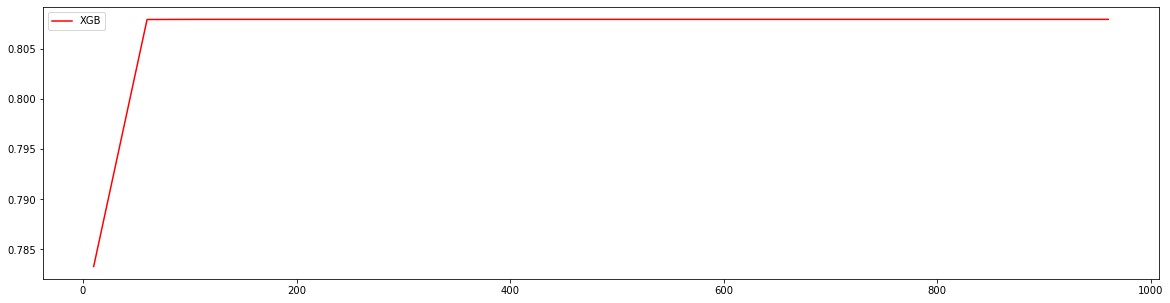

In [10]:
axisx = range(10, 1010, 50)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=i, random_state=420)
    cvresult = CVS(reg, Xtrain, Ytrain, cv=cv)
    #记录1-偏差
    rs.append(cvresult.mean())
    #记录方差
    var.append(cvresult.var())
    #计算泛化误差的可控部分
    ge.append((1 - cvresult.mean()) ** 2 + cvresult.var())
#打印R2最高所对应的参数取值，并打印这个参数下的方差
print(axisx[rs.index(max(rs))], max(rs), var[rs.index(max(rs))])
#打印方差最低时对应的参数取值，并打印这个参数下的R2
print(axisx[var.index(min(var))], rs[var.index(min(var))], min(var))
#打印泛化误差可控部分的参数取值，并打印这个参数下的R2，方差以及泛化误差的可控部分
print(axisx[ge.index(min(ge))], rs[ge.index(min(ge))], var[ge.index(min(ge))], min(ge))
plt.figure(figsize=(20, 5))
plt.plot(axisx, rs, c="red", label="XGB")
plt.legend()
plt.show()

8. **细化学习曲线，找出最佳n_estimators**

80 0.8080024586069688 0.0056090923734559515
58 0.8079838987836767 0.0056023510948014854
80 0.8080024586069688 0.0056090923734559515 0.042472148274424665


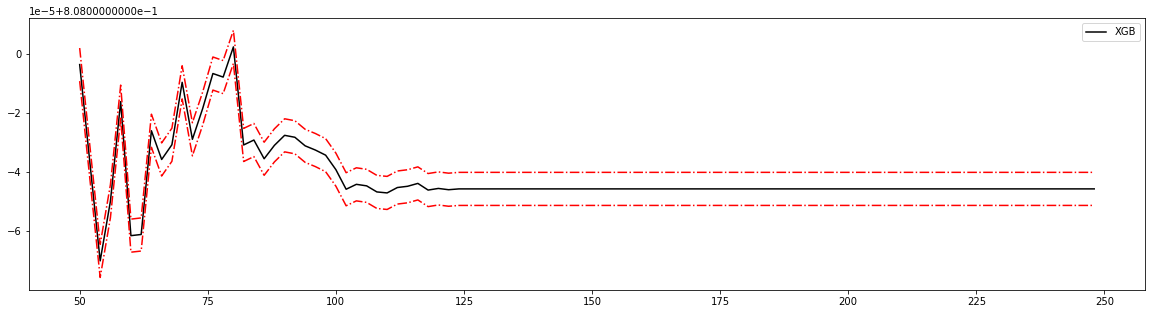

In [11]:
axisx = range(50, 250, 2)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=i, random_state=420)
    cvresult = CVS(reg, Xtrain, Ytrain, cv=cv)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean()) ** 2 + cvresult.var())
print(axisx[rs.index(max(rs))], max(rs), var[rs.index(max(rs))])
print(axisx[var.index(min(var))], rs[var.index(min(var))], min(var))
print(axisx[ge.index(min(ge))], rs[ge.index(min(ge))], var[ge.index(min(ge))], min(ge))
rs = np.array(rs)
var = np.array(var) * 0.001
plt.figure(figsize=(20, 5))
plt.plot(axisx, rs, c="black", label="XGB")
# 添加方差线
plt.plot(axisx, rs + var, c="red", linestyle='-.')
plt.plot(axisx, rs - var, c="red", linestyle='-.')
plt.legend()
plt.show()

9. **检验模型效果**

In [12]:
# 验证模型效果是否提高了？
time0 = time()
print(XGBR(n_estimators=100, random_state=420).fit(Xtrain, Ytrain).score(Xtest, Ytest))
print(time() - time0)

time0 = time()
print(XGBR(n_estimators=80, random_state=420).fit(Xtrain, Ytrain).score(Xtest, Ytest))
print(time() - time0)

time0 = time()
print(XGBR(n_estimators=58, random_state=420).fit(Xtrain, Ytrain).score(Xtest, Ytest))
print(time() - time0)

0.9050988968414799
0.050241947174072266
0.9051307509995244
0.04799222946166992
0.9050340691862288
0.018222808837890625


从这个过程中观察n_estimators参数对模型的影响，我们可以得出以下结论：

首先，XGB中的树的数量决定了模型的学习能力，树的数量越多，模型的学习能力越强。只要XGB中树的数量足够了，即便只有很少的数据，模型也能够学到训练数据100%的信息，所以XGB也是天生过拟合的模型。但在这种情况下，模型会变得非常不稳定。

第二，XGB中树的数量很少的时候，对模型的影响较大，当树的数量已经很多的时候，对模型的影响比较小，只能有微弱的变化。当数据本身就处于过拟合的时候，再使用过多的树能达到的效果甚微，反而浪费计算资源。当唯一指标或者准确率给出的n_estimators看起来不太可靠的时候，我们可以改造学习曲线来帮助我们。

第三，树的数量提升对模型的影响有极限，最开始，模型的表现会随着XGB的树的数量一起提升，但到达某个点之后，树的数量越多，模型的效果会逐步下降，这也说明了暴力增加n_estimators不一定有效果。

这些都和随机森林中的参数n_estimators表现出一致的状态。在随机森林中总是先调整n_estimators，当n_estimators的极限已达到，我们才考虑其他参数，但XGB中的状况明显更加复杂，当数据集不太寻常的时候会更加复杂。这是我们要给出的第一个超参数，因此还是建议优先调整n_estimators，一般都不会建议一个太大的数目，300以下为佳。

## 2.2 有放回随机抽样：重要参数subsample

在梯度提升树中，我们每一次迭代都要建立一棵新的树，因此我们每次迭代中，都要有放回抽取一个新的训练样本。不过，这并不能保证每次建新树后，集成的效果都比之前要好。因此我们规定，**在梯度提升树中，每构建一个评估器，都让模型更加集中于数据集中容易被判错的那些样本**。来看看下面的这个过程。
### 截图
对于一个样本而言，它被预测错误的次数越多，被加大权重的次数也就越多。**我们相信，只要弱分类器足够强大，随着模型整体不断在被判错的样本上发力，这些样本会渐渐被判断正确**。如此就一定程度上实现了我们每新建一棵树模型的效果都会提升的目标。

在sklearn中，我们使用参数subsample来控制随机抽样。在xgb和sklearn中，这个参数都默认为1且不能取到0，范围为(0,1]，这说明我们无法控制模型是否进行随机有放回抽样，数字表示抽样抽出来的样本比例是多少。

除了让模型更加集中于那些困难样本，采样还对模型造成了什么样的影响呢？采样会减少样本数量，而从学习曲线来看样本数量越少模型的过拟合会越严重，因为对模型来说，数据量越少模型学习越容易，学到的规则也会越具体越不适用于测试样本。**所以subsample参数通常是在样本量本身很大的时候来调整和使用**。

**正常来说样本量越大，模型不容易过拟合**，我们的模型现在正处于样本量过少并且过拟合的状态，调整subsample参数对模型的影响应该会非常不稳定，大概率应该是无法提升模型的泛化能力的，但也不乏提升模型的可能性。依然使用波士顿房价数据集，来看学习曲线：

1.0 0.8080024586069688


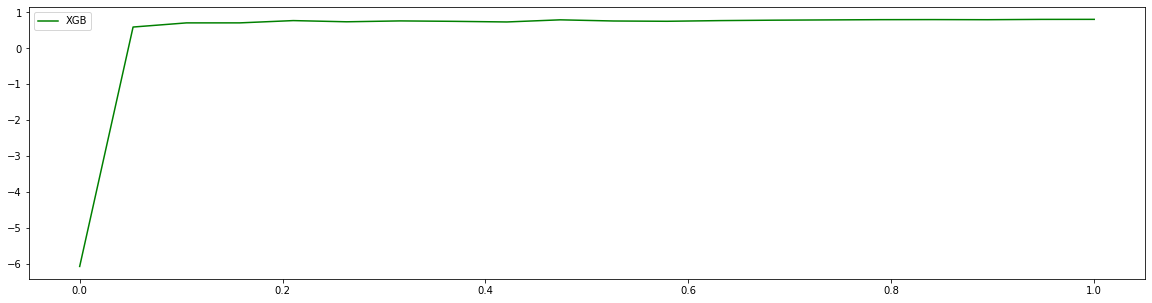

In [13]:
axisx = np.linspace(0, 1, 20)
rs = []
for i in axisx:
    reg = XGBR(n_estimators=80, subsample=i, random_state=420)
    rs.append(CVS(reg, Xtrain, Ytrain, cv=cv).mean())
print(axisx[rs.index(max(rs))], max(rs))
plt.figure(figsize=(20, 5))
plt.plot(axisx, rs, c="green", label="XGB")
plt.legend()
plt.show()

0.9379310344827586 0.8154050684565389 0.005439844112307734
0.7103448275862069 0.8009461893365051 0.00328438821296457
0.9379310344827586 0.8154050684565389 0.005439844112307734 0.03951513286384281


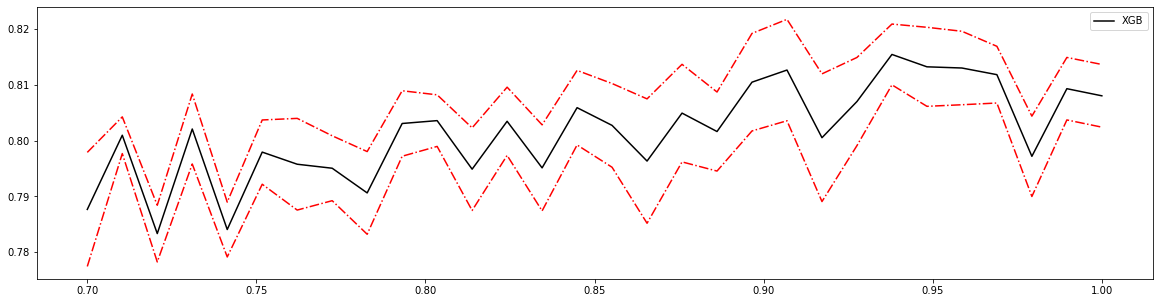

In [14]:
# 细化学习曲线
# axisx = np.linspace(0.05, 1, 20)
# 继续细化学习曲线
axisx = np.linspace(0.7, 1, 30)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=80, subsample=i, random_state=420)
    cvresult = CVS(reg, Xtrain, Ytrain, cv=cv)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean()) ** 2 + cvresult.var())
print(axisx[rs.index(max(rs))], max(rs), var[rs.index(max(rs))])
print(axisx[var.index(min(var))], rs[var.index(min(var))], min(var))
print(axisx[ge.index(min(ge))], rs[ge.index(min(ge))], var[ge.index(min(ge))], min(ge))
rs = np.array(rs)
var = np.array(var)
plt.figure(figsize=(20, 5))
plt.plot(axisx, rs, c="black", label="XGB")
plt.plot(axisx, rs + var, c="red", linestyle='-.')
plt.plot(axisx, rs - var, c="red", linestyle='-.')
plt.legend()
plt.show()

In [15]:
reg = XGBR(n_estimators=80, subsample=0.9379310344827586, random_state=420).fit(Xtrain, Ytrain)
print(reg.score(Xtest, Ytest), MSE(Ytest, reg.predict(Xtest)))

0.9158194585547765 7.833326426379364


令人意外的是，参数的调整使模型在测试集上的效果上升了，还是挺让人惊喜的。如果效果下降，我们就把这个参数就保持默认为1就行了。


## 2.3 迭代决策树：重要参数eta
除了保证模型逐渐倾向于困难样本的方向，还必须控制新弱分类器的生成，我们必须保证，每次新添加的树一定得是对这个新数据集预测效果最优的那一棵树。
### 截图
利用梯度下降来迭代我们的集成算法：
$$\hat{y_i}^{(k+1)}=\hat{y_i}^{(k)}+\eta f_{k+1}(x_i)$$


其中$\eta$读作"eta"，是迭代决策树时的步长（shrinkage），又叫做学习率（learning rate）。和逻辑回归中的$\alpha$类似，$\eta$越大，迭代的速度越快，算法的极限很快被达到，有可能无法收敛到真正的最佳。$\eta$越小，越有可能找到更精确的最佳值，更多的空间被留给了后面建立的树，但迭代速度会比较缓慢。
### 截图
在sklearn中，我们使用参数learning_rate来干涉我们的学习速率：

In [16]:
# 首先先来定义一个评分函数，这个评分函数能够直接打印Xtrain上的交叉验证结果
def regassess(reg, Xtrain, Ytrain, cv, scoring=["r2"], show=True):
    score = []
    for i in range(len(scoring)):
        if show:
            print("{}:{:.2f}".format(scoring[i], CVS(reg, Xtrain, Ytrain, cv=cv, scoring=scoring[i]).mean()))
        score.append(CVS(reg, Xtrain, Ytrain, cv=cv, scoring=scoring[i]).mean())
    return score


reg = XGBR(n_estimators=80, random_state=420).fit(Xtrain, Ytrain)
regassess(reg, Xtrain, Ytrain, cv, scoring=["r2", "neg_mean_squared_error"], show=False)

[0.8080024586069688, -15.327830589857454]

In [17]:
# 观察一下eta如何影响模型的效果
from time import time
import datetime

for i in [0, 0.2, 0.5, 1]:
    time0 = time()
    reg = XGBR(n_estimators=80, random_state=420, learning_rate=i).fit(Xtrain, Ytrain)
    print("learning_rate={}".format(i))
    regassess(reg, Xtrain, Ytrain, cv, scoring=["r2", "neg_mean_squared_error"])
    print(datetime.datetime.fromtimestamp(time() - time0).strftime("%M:%S:%f"))
    print("\t")

learning_rate=0
r2:-6.07
neg_mean_squared_error:-567.45
00:00:501172
	
learning_rate=0.2
r2:0.81
neg_mean_squared_error:-14.84
00:00:636278
	
learning_rate=0.5
r2:0.79
neg_mean_squared_error:-16.49
00:00:587384
	
learning_rate=1
r2:0.68
neg_mean_squared_error:-25.66
00:00:412784
	


除了运行时间，步长还是一个对模型效果影响巨大的参数，如果设置太大模型就无法收敛（可能导致很小$R^2$或者$MSE$很大的情况），如果设置太小模型速度就会非常缓慢，但它最后究竟会收敛到何处很难由经验来判定，在训练集上表现出来的模样和在测试集上相差甚远，很难直接探索出一个泛化误差很低的步长。

0.35000000000000003 0.8218186517867974


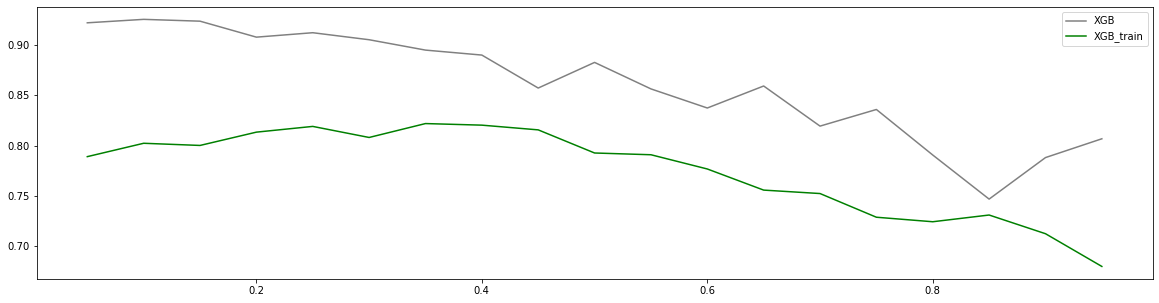

In [18]:
axisx = np.arange(0.05, 1, 0.05)
rs = []  # 训练集上的r2
te = []  # 测试集上的r2
for i in axisx:
    reg = XGBR(n_estimators=80, random_state=420, learning_rate=i)
    score = regassess(reg, Xtrain, Ytrain, cv, scoring=["r2", "neg_mean_squared_error"], show=False)
    test = reg.fit(Xtrain, Ytrain).score(Xtest, Ytest)
    rs.append(score[0])
    te.append(test)
print(axisx[rs.index(max(rs))], max(rs))
plt.figure(figsize=(20, 5))
plt.plot(axisx, te, c="gray", label="XGB")
plt.plot(axisx, rs, c="green", label="XGB_train")
plt.legend()
plt.show()

虽然从图上来说，默认的0.1看起来是一个比较理想的情况，并且看起来更小的步长更利于现在的数据，但我们也无法确定对于其他数据会有怎么样的效果。**所以通常，我们不调整$\eta$，即便调整，一般它也会在[0.01,0.2]之间变动**。如果我们希望模型的效果更好，更多的可能是从树本身的角度来说，对树进行剪枝，而不会寄希望于调整$\eta$。

梯度提升树是XGB的基础，本节中已经介绍了XGB中与梯度提升树的过程相关的四个参数：**n_estimators，learning_rate，silent(新版本变为verbosity)，subsample**。这四个参数的主要目的，其实并不是提升模型表现，更多是了解梯度提升树的原理。现在来看，梯度提升树可是说是由三个重要的部分组成：
1. 一个能够衡量集成算法效果的，能够被最优化的损失函数$Obj$
2. 一个能够实现预测的弱评估器$f_k{(x)}$
3. 一种能够让弱评估器集成的手段，包括迭代方法，抽样手段，样本加权等等过程


XGBoost是在梯度提升树的这三个核心要素上运行，它重新定义了损失函数和弱评估器，并且对提升算法的集成手段进行了改进，实现了运算速度和模型效果的高度平衡。并且XGBoost将原本的梯度提升树拓展开来，让XGBoost不再是单纯的树的集成模型，也不只是单单的回归模型。只要我们调节参数，我们可以选择任何我们希望集成的算法，以及任何我们希望实现的功能。

# 3 XGBoost的智慧
`class xgboost.XGBRegressor (kwargs，max_depth=3, learning_rate=0.1, n_estimators=100, silent=True,objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1,max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1,scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, importance_type='gain')
`
## 3.1 选择弱评估器：重要参数booster

梯度提升算法中不只有梯度提升树，XGB作为梯度提升算法的进化，自然也不只有树模型一种弱评估器。在XGB中，除了树模型，我们还可以选用线性模型，比如线性回归，来进行集成。虽然主流的XGB依然是树模型，但也可以使用其他的模型。基于XGB的这种性质，由参数“booster"来控制
### 截图
两个参数都默认为"gbtree"，如果不想使用树模型，则可以自行调整。简单看看现有的数据集上，是什么样的弱评估器表现更好：

In [19]:
for booster in ["gbtree", "gblinear", "dart"]:
    reg = XGBR(n_estimators=80, random_state=420, booster=booster, learning_rate=0.1).fit(Xtrain, Ytrain)
    print(booster)
    print(reg.score(Xtest, Ytest))

gbtree
0.9253861311802936
gblinear
0.5597717916053191
dart
0.9253861457985542


## 3.2 XGB的目标函数：重要参数objective
**集成算法中的损失函数是可选的**，要选用什么损失函数取决于我们希望解决什么问题，以及希望使用怎样的模型。比如说，如果我们的目标是进行回归预测，那我们可以选择调节后的均方误差RMSE作为我们的损失函数。如果我们是进行分类预测，那我们可以选择错误率error或者对数损失log_loss。只要我们选出的函数是一个可微的，能够代表某种损失的函数，它就可以是我们XGB中的损失函数。

在众多机器学习算法中，损失函数的核心是衡量模型的泛化能力，即模型在未知数据上的预测的准确与否，训练模型的核心目标也是希望模型能够预测准确。在XGB中，预测准确自然是非常重要的因素，但之前提到过，**XGB的是实现了模型表现和运算速度的平衡的算法**。普通的损失函数，比如错误率，均方误差等，都只能够衡量模型的表现，无法衡量模型的运算速度。XGB因此引入了模型复杂度来衡量算法的运算效率。因此XGB的目标函数被写作：传统损失函数+模型复杂度。
$$Obj=\sum_{i=1}^m l(y_i,\hat{y_i})+\sum_{k=1}^K\Omega(f_k)$$
其中$i$代表数据集中的第$i$个样本，$m$表示导入第$k$棵树的数据总量，$K$代表建立的所有树(n_estimators)，当只建立了$t$棵树的时候，式子应当为$\sum_{k=1}^t\Omega(f_k)$。第一项代表传统的损失函数，衡量真实标签与预测值之间的差异，通常是$RMSE$，即调节后的均方误差。第二项代表模型的复杂度，使用树模型的某种变换$\Omega$表示，这个变化代表了一个从树的结构来衡量树模型的复杂度的式子，可以有多种定义。**注意，第二项中没有特征矩阵$x_i$的介入**。在迭代每一棵树的过程中，都最小化$Obj$来力求获取最优的$\hat y$，因此同时最小化了模型的错误率和模型的复杂度。

第一项是衡量偏差，模型越不准确，第一项就会越大。第二项是衡量方差，模型越复杂，模型的学习就会越具体，到不同数据集上的表现就会差异巨大，方差就会越大。所以求解$Obj$的最小值，其实是在求解方差与偏差的平衡点，以求模型的泛化误差最小，运行速度最快。

在应用中，使用参数“objective"来确定目标函数第一部分中的$l(y_i,\hat{y_i})$，也就是衡量损失的部分。
### 截图
在xgboost中，被允许自定义损失函数，但通常我们还是使用类已经为我们设置好的损失函数。回归类中本来使用的就是reg:linear(注：现在使用reg:squarederror来代替reg:linear)，因此在这里无需做任何调整。注意：**分类型的目标函数导入回归类中会直接报错**。现在来试试看xgb自身的调用方式。
### 截图
由于xgb中所有的参数都需要自己的输入，并且objective参数的默认值是二分类，因此我们必须手动调节。试试看在其他参数相同的情况下，xgboost库本身和sklearn比起来，效果如何：

In [20]:
# sklearn中的xgb实现法
reg = XGBR(n_estimators=80, random_state=420).fit(Xtrain, Ytrain)
print("sklearn实现法\t", reg.score(Xtest, Ytest), MSE(Ytest, reg.predict(Xtest)))

# xgb实现法
import xgboost as xgb

# 使用DMatirx读取数据
dtrain = xgb.DMatrix(Xtrain, Ytrain)
dtest = xgb.DMatrix(Xtest, Ytest)
# 设置参数，verbosity=0为关闭所有打印信息
param = {'verbosity': 0, 'objective': 'reg:squarederror', 'eta': 0.1}
num_round = 80  # 迭代80次，即80棵树
# 类train，可以直接导入的参数是训练数据，树的数量，其他参数都需要通过params来导入
bst = xgb.train(param, dtrain, num_round)
# 使用bst.predict来预测
from sklearn.metrics import r2_score

print("xgb实现法\t", r2_score(Ytest, bst.predict(dtest)), MSE(Ytest, bst.predict(dtest)))

sklearn实现法	 0.9051307509995244 8.827952190468553
xgb实现法	 0.9253861311802936 6.943110371654348


看得出来，无论是从$R^2$还是从$MSE$的角度来看，都是xgb库本身表现更优秀，这也许是由于底层的代码是由不同团队创造的缘故。随着样本量的逐渐上升，sklearnAPI中调用的结果与xgboost中直接训练的结果会比较相似，如果希望的话可以分别训练，然后选取泛化误差较小的库。**如果可以的话，建议脱离sklearnAPI直接调用xgboost库，因为xgboost库本身的调参要方便许多**。

## 3.4 参数化决策树 ：正则化参数$\alpha$，$\lambda$


我们定义了树和树的复杂度的表达式，树我们使用叶子节点上的预测分数来表达，而树的复杂度则是叶子数目加上正则项($\alpha$控制$L1$正则项，$\lambda$控制$L2$正则项)：
$$f_t(x_i)=w_{q(x_i)} \quad,\quad \Omega(f_t)=\gamma T+\frac{1}{2}\lambda\sum_{j=1}^Tw_j^2$$
在普通的梯度提升树GBDT中是不在目标函数中使用正则项的，但XGB借用正则项来修正树模型天生容易过拟合这个缺陷，在剪枝之前让模型能够尽量不过拟合。
### 截图
当$\lambda$和$\alpha$越大，惩罚越重，正则项所占的比例就越大，在尽全力最小化目标函数的最优化方向下，叶子节点数量就会被压制，模型的复杂度就越来越低，所以对于天生过拟合的XGB来说，正则化可以一定程度上提升模型效果。

对于两种正则化如何选择的问题，从XGB的默认参数来看，**优先选择的是L2正则化**。当然，如果想尝试L1也不是不可。两种正则项还可以交互，因此这两个参数的使用其实比较复杂。在实际应用中，正则化参数往往不是我们调参的最优选择，**如果真的希望控制模型复杂度，我们会调整$\gamma$而不是调整这两个正则化参数**，因此不必过于在意这两个参数最终如何影响模型效果。**对于树模型来说，还是剪枝参数地位更高更优先**。只需要理解这两个参数从数学层面上如何影响我们的模型就足够了。如果我们希望调整$\lambda$和$\alpha$，往往会使用网格搜索。下面是网格搜索的参考代码和结果：

In [21]:
# 使用网格参数来查找最佳的参数组合
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE, r2_score

param = {'reg_alpha': np.arange(0, 5, 0.05), 'reg_lambda': np.arange(0, 2, 0.05)}
gscv = GridSearchCV(reg, param_grid=param, scoring='neg_mean_squared_error', cv=cv)

time0 = time()
gscv.fit(Xtrain, Ytrain)
print("网格搜索共耗时：", datetime.datetime.fromtimestamp(time() - time0).strftime("%M:%S:%f"))
print("网格搜索的最佳参数组合为：", gscv.best_params_)
print("网格搜索的最佳分数为：", gscv.best_score_)
preds = gscv.predict(Xtest)  # 预测测试集
print("网格搜索的R2为：", r2_score(Ytest, preds))
print("网格搜索的MSE为：", MSE(Ytest, preds))

网格搜索共耗时： 07:24:935135
网格搜索的最佳参数组合为： {'reg_alpha': 0.8, 'reg_lambda': 1.0}
网格搜索的最佳分数为： -12.275481385230702
网格搜索的R2为： 0.9130557104613134
网格搜索的MSE为： 8.09050392375229


## 3.5 寻找最佳树结构：求解$\omega$与$T$

## 3.6 寻找最佳分枝：结构分数之差

## 3.7 让树停止生长：重要参数$\gamma$

实践证明，$\gamma$是对梯度提升树影响最大的参数之一，其效果丝毫不逊色于n_estimators和防止过拟合的神器max_depth。同时，还是让树停止生长的重要参数。$\gamma$设定越大，算法就越保守，树的叶子数量就越少，模型的复杂度就越低。
### 截图
下面这段代码是让参数$\gamma$在0~5之间均匀取值的学习曲线。其运行速度较缓慢并且曲线的效果匪夷所思:

2.75 0.8137481210766623 0.00640085468069366
0.05 0.8088111534340722 0.0055552195352232625
2.75 0.8137481210766623 0.00640085468069366 0.041090617083167316


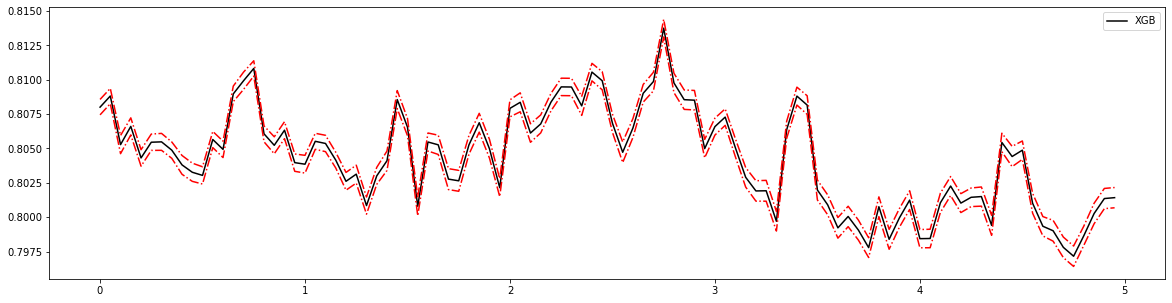

In [24]:
axisx = np.arange(0, 5, 0.05)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=80, random_state=420, gamma=i)
    cvresult = CVS(reg, Xtrain, Ytrain, cv=cv)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean()) ** 2 + cvresult.var())
print(axisx[rs.index(max(rs))], max(rs), var[rs.index(max(rs))])
print(axisx[var.index(min(var))], rs[var.index(min(var))], min(var))
print(axisx[ge.index(min(ge))], rs[ge.index(min(ge))], var[ge.index(min(ge))], min(ge))
rs = np.array(rs)
var = np.array(var) * 0.1
plt.figure(figsize=(20, 5))
plt.plot(axisx, rs, c="black", label="XGB")
plt.plot(axisx, rs + var, c="red", linestyle="-.")
plt.plot(axisx, rs - var, c="red", linestyle="-.")
plt.legend()
plt.show()

可以看到，我们完全无法从中看出什么趋势，偏差时高时低，方差时大时小，参数引起的波动远远超过其他参数（其他参数至少还有一个先上升再平稳的过程，而则是仿佛完全无规律）。在sklearn下XGBoost太不稳定，如果这样来调整参数的话，效果就很难保证。因此，为了调整，我们需要来引入新的工具，xgboost库中的类xgboost.cv。

`xgboost.cv (params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None,feval=None, maximize=False, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None,show_stdv=True, seed=0, callbacks=None, shuffle=True)`

In [25]:
import xgboost as xgb

# 为了便捷，使用全数据
dfull = xgb.DMatrix(X, y)

# 设定参数
param = {'verbosity': 0, 'obj': 'reg:squarederror', 'gamma': 0}
num_round = 80
n_fold = 5

# 使用xgb.cv
time0 = time()
cvresult = xgb.cv(param, dfull, num_round, n_fold)
print(datetime.datetime.fromtimestamp(time() - time0).strftime("%M:%S:%f"))

00:00:273658


看看xgb.cv生成了什么结果：

In [32]:
cvresult.head(10)  # 随着树的增加，训练集和测试集的均方误差都在减小

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,17.105578,0.129116,17.163215,0.584297
1,12.337973,0.097557,12.519736,0.473458
2,8.994071,0.065756,9.404534,0.472310
3,6.629481,0.050323,7.250335,0.500342
4,4.954406,0.033209,5.920812,0.591874
5,3.781454,0.029604,5.045190,0.687971
6,2.947768,0.038786,4.472030,0.686492
7,2.357748,0.042040,4.179314,0.737935
8,1.951907,0.044972,3.979878,0.798198
9,1.660895,0.044894,3.870751,0.812331


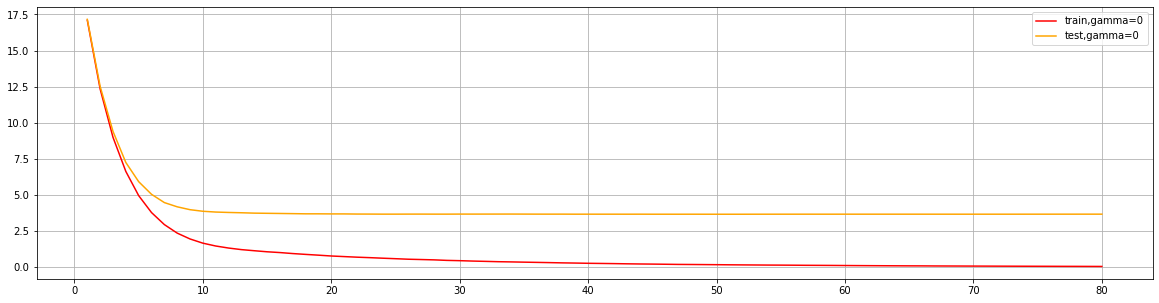

In [29]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(range(1, 81), cvresult.iloc[:, 0], c="red", label="train,gamma=0")
plt.plot(range(1, 81), cvresult.iloc[:, 2], c="orange", label="test,gamma=0")
plt.legend()
plt.show()

为了使用xgboost.cv，我们必须要熟悉xgboost自带的模型评估指标。xgboost在建库的时候本着大而全的目标，和sklearn类似，包括了大约20个模型评估指标，然而用于回归和分类的其实只有几个，大部分是用于一些更加高级的功能比如ranking。来看用于回归和分类的评估指标都有哪些：
### 截图

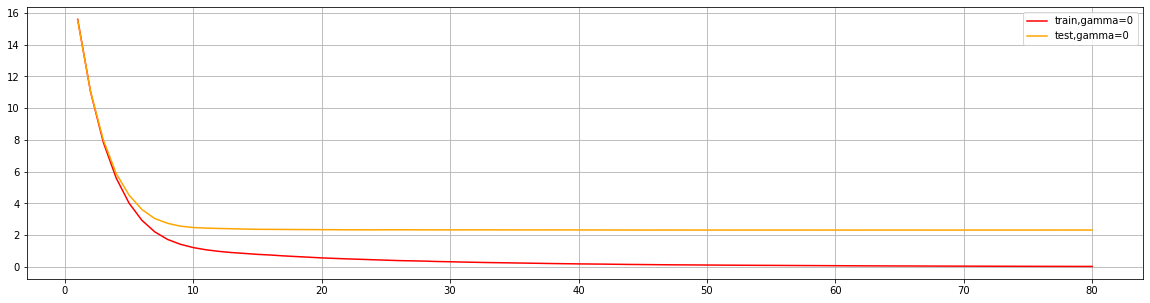

In [38]:
param = {'verbosity': 0, 'obj': 'reg:squarederror', 'gamma': 0, "eval_metric": "mae"}
num_round = 80
n_fold = 5

cvresult = xgb.cv(param, dfull, num_round, n_fold)
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(range(1, 81), cvresult.iloc[:, 0], c="red", label="train,gamma=0")
plt.plot(range(1, 81), cvresult.iloc[:, 2], c="orange", label="test,gamma=0")
plt.legend()
plt.show()

来看看如果调整$\gamma$，会发生怎样的变化:

00:00:249844
00:00:266581


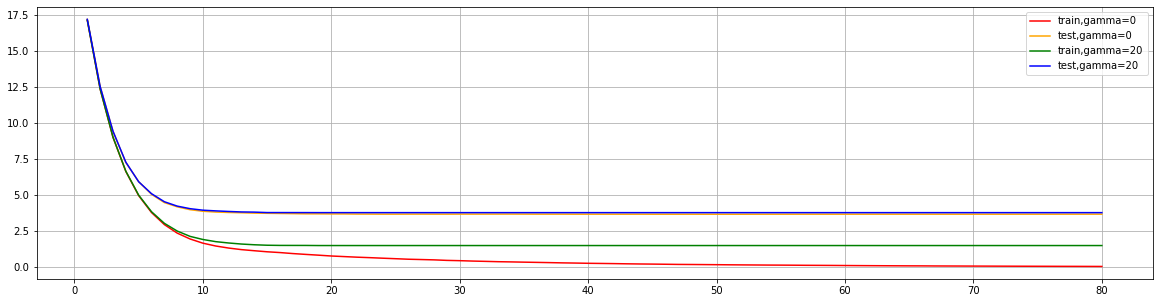

In [53]:
param1 = {'verbosity': 0, 'obj': 'reg:squarederror', 'gamma': 0}
param2 = {'verbosity': 0, 'obj': 'reg:squarederror', 'gamma': 20}
num_round = 80
n_fold = 5

time1 = time()
cvresult1 = xgb.cv(param1, dfull, num_round, n_fold)
print(datetime.datetime.fromtimestamp(time() - time1).strftime("%M:%S:%f"))

time2 = time()
cvresult2 = xgb.cv(param2, dfull, num_round, n_fold)
print(datetime.datetime.fromtimestamp(time() - time2).strftime("%M:%S:%f"))

plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(range(1, 81), cvresult1.iloc[:, 0], c="red", label="train,gamma=0")
plt.plot(range(1, 81), cvresult1.iloc[:, 2], c="orange", label="test,gamma=0")
plt.plot(range(1, 81), cvresult2.iloc[:, 0], c="green", label="train,gamma=20")
plt.plot(range(1, 81), cvresult2.iloc[:, 2], c="blue", label="test,gamma=20")
plt.legend()
plt.show()

可以看出可以通过增大$\gamma$来控制模型过拟合，具体是降低训练集上的表现，使训练集和测试集的表现更加接近，从而提升模型泛化能力。

试一个分类的例子：

00:00:234972
00:00:390831


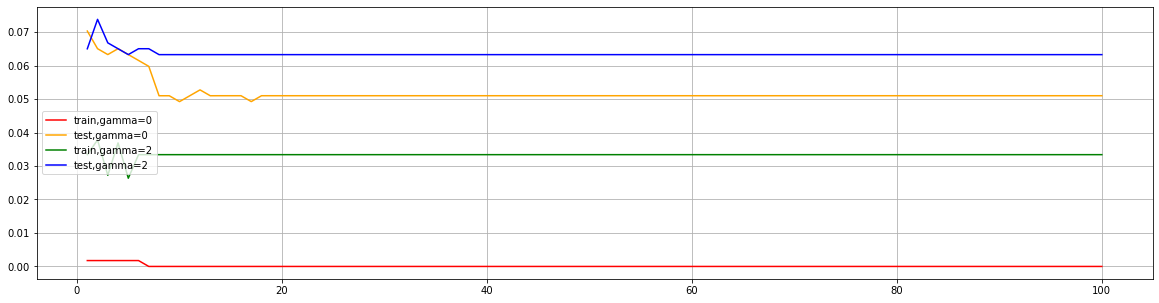

In [68]:
from sklearn.datasets import load_breast_cancer

data2 = load_breast_cancer()

x2 = data2.data
y2 = data2.target

dfull2 = xgb.DMatrix(x2, y2)

param1 = {'obj': 'binary:logistic', "gamma": 0, "nfold": 5}
param2 = {'obj': 'binary:logistic', "gamma": 2, "nfold": 5}
num_round = 100

time0 = time()
cvresult1 = xgb.cv(param1, dfull2, num_round, metrics=["error"])
print(datetime.datetime.fromtimestamp(time() - time0).strftime("%M:%S:%f"))

time0 = time()
cvresult2 = xgb.cv(param2, dfull2, num_round, metrics=["error"])
print(datetime.datetime.fromtimestamp(time() - time0).strftime("%M:%S:%f"))

plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(range(1, 101), cvresult1.iloc[:, 0], c="red", label="train,gamma=0")
plt.plot(range(1, 101), cvresult1.iloc[:, 2], c="orange", label="test,gamma=0")
plt.plot(range(1, 101), cvresult2.iloc[:, 0], c="green", label="train,gamma=2")
plt.plot(range(1, 101), cvresult2.iloc[:, 2], c="blue", label="test,gamma=2")
plt.legend()
plt.show()

有了xgboost.cv这个工具，参数调整就容易多了。这个工具可以让我们直接看到参数如何影响了模型的泛化能力。

# 4 XGBoost应用中的其他问题
## 4.1 过拟合：剪枝参数与回归模型调参

`class xgboost.XGBRegressor (max_depth=3, learning_rate=0.1, n_estimators=100, silent=True,objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1,max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1,scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, importance_type='gain', kwargs)`
作为天生过拟合的模型，XGBoost应用的核心之一就是减轻过拟合带来的影响。在前文中已经了解了好几个可以用来防止过拟合的参数：复杂度控制$\gamma$，正则化的两个参数$\alpha$和$\lambda$，控制迭代速度的参数$\eta$以及管理每次迭代前进行的随机有放回抽样的参数subsample。所有的这些参数都可以用来减轻过拟合。但除此之外，我们还有几个影响重大的，专用于剪枝的参数：
### 截图

这些参数中，树的最大深度是决策树中的剪枝法宝，算是最常用的剪枝参数，不过在XGBoost中，最大深度的功能与参数$\gamma$相似，因此如果先调节了$\gamma$，则最大深度可能无法展示出巨大的效果。当然，如果先调整了最大深度，则$\gamma$也有可能无法显示明显的效果。通常来说，这两个参数中我们只使用一个，不过两个都试试也没有坏处。

三个随机抽样特征的参数中，前两个比较常用。在建立树时对特征进行抽样其实是决策树和随机森林中比较常见的一种方法，但是在XGBoost之前，这种方法并没有被使用到boosting算法当中过。Boosting算法一直以抽取样本（横向抽样）来调整模型过拟合的程度，而实践证明其实纵向抽样（抽取特征）更能够防止过拟合。

通常当我们获得了一个数据集后，我们先使用网格搜索找出比较合适的n_estimators和eta组合，然后使用gamma或者max_depth观察模型处于什么样的状态（过拟合还是欠拟合，处于方差-偏差图像的左边还是右边？），最后再决定是否要进行剪枝。通常来说，对于XGB模型，大多数时候都是需要剪枝的。接下来我们就来看看使用xgb.cv这个类来进行剪枝调参，以调整出一组泛化能力很强的参数(调参侠上线！)。
让我们先从最原始的，设定默认参数开始，先观察一下默认参数下，我们的交叉验证曲线长什么样：

00:00:532119


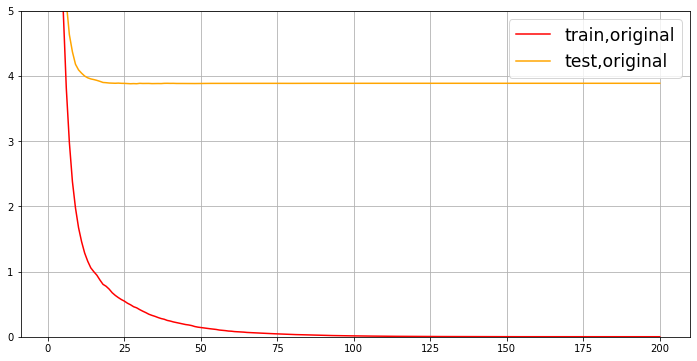

In [20]:
import xgboost as xgb

dfull = xgb.DMatrix(X, y)
param1 = {'verbosity': 0, 'obj': 'reg:squarederror', 'subsample': 1, 'max_depth': 6, 'eta': 0.3, 'gamma': 0,
          'lambda': 1, 'alpha': 0, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'nfold': 5}
num_round = 200

time0 = time()
cvresult1 = xgb.cv(param1, dfull, num_round)
print(datetime.datetime.fromtimestamp(time() - time0).strftime("%M:%S:%f"))

fig, ax = plt.subplots(1, figsize=(12, 6))
ax.grid()
ax.set_ylim(top=5)
ax.plot(range(1, 201), cvresult1.iloc[:, 0], c="red", label="train,original")
ax.plot(range(1, 201), cvresult1.iloc[:, 2], c="orange", label="test,original")
ax.legend(fontsize="xx-large")  # 字体加大
plt.show()

从曲线上可以看出，模型现在处于过拟合的状态。我们决定要进行剪枝。我们的目标是：训练集和测试集的结果尽量接近，如果测试集上的结果不能上升，那训练集上的结果降下来也是不错的选择（让模型不那么具体到训练数据，增加泛化能力）。在这里，我们要使用三组曲线。一组用于展示原始数据上的结果，一组用于展示上一个参数调节完毕后的结果，最后一组用于展示现在我们在调节的参数的结果。具体使用：

00:00:574137
00:00:297467
00:00:257747


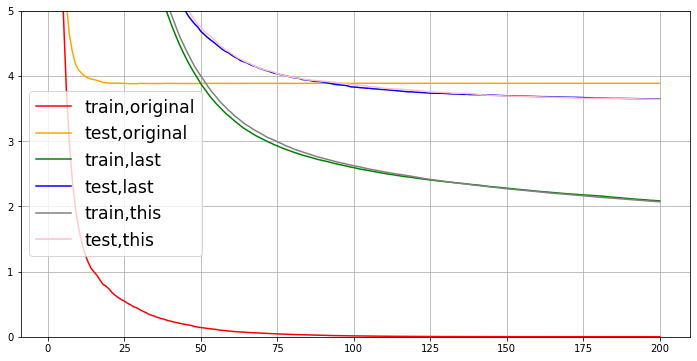

In [79]:
param1 = {'verbosity': 0, 'obj': 'reg:squarederror', 'subsample': 1, 'max_depth': 6, 'eta': 0.3, 'gamma': 0,
          'lambda': 1, 'alpha': 0, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'nfold': 5}
param2 = {'verbosity': 0, 'obj': 'reg:squarederror', 'subsample': 1, 'max_depth': 2, 'eta': 0.05, 'gamma': 0,
          'lambda': 1, 'alpha': 0, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'nfold': 5}
# 最佳参数组合：调参顺序：先mx_depth(或者gamma)，eta(配合n_estimators)，采样和抽样参数（纵向抽样影响更大），最后正则化系数(labmda，alpha)
param3 = {'verbosity': 0, 'obj': 'reg:squarederror', 'subsample': 1, 'max_depth': 2, 'eta': 0.05, 'gamma': 0,
          'lambda': 1, 'alpha': 0, 'colsample_bytree': 1, 'colsample_bylevel': 0.4, 'colsample_bynode': 1, 'nfold': 5}
num_round = 200

time0 = time()
cvresult1 = xgb.cv(param1, dfull, num_round)
print(datetime.datetime.fromtimestamp(time() - time0).strftime("%M:%S:%f"))

time0 = time()
cvresult2 = xgb.cv(param2, dfull, num_round)
print(datetime.datetime.fromtimestamp(time() - time0).strftime("%M:%S:%f"))

time0 = time()
cvresult3 = xgb.cv(param3, dfull, num_round)
print(datetime.datetime.fromtimestamp(time() - time0).strftime("%M:%S:%f"))

fig, ax = plt.subplots(1, figsize=(12, 6))
ax.set_ylim(top=5)
ax.grid()
ax.plot(range(1, num_round + 1), cvresult1.iloc[:, 0], c="red", label="train,original")
ax.plot(range(1, num_round + 1), cvresult1.iloc[:, 2], c="orange", label="test,original")
ax.plot(range(1, num_round + 1), cvresult2.iloc[:, 0], c="green", label="train,last")
ax.plot(range(1, num_round + 1), cvresult2.iloc[:, 2], c="blue", label="test,last")
ax.plot(range(1, num_round + 1), cvresult3.iloc[:, 0], c="gray", label="train,this")
ax.plot(range(1, num_round + 1), cvresult3.iloc[:, 2], c="pink", label="test,this")
ax.legend(fontsize="xx-large")
plt.show()

## 4.2 XGBoost模型的保存和调用
在使用Python进行编程时，我们可能会需要编写较为复杂的程序或者建立复杂的模型。比如XGBoost模型，这个模型的参数复杂繁多，并且调参过程不是太容易，一旦训练完毕，我们往往希望将训练完毕后的模型保存下来，以便日后用于新的数据集。在Python中，保存模型的方法有许多种。以XGBoost为例，来介绍两种主要的模型保存和调用方法。

### 4.2.1 使用Pickle保存和调用模型
pickle是Python编程中比较标准的一个保存和调用模型的库，可以使用pickle和open函数的连用，来将我们的模型保存到本地。以刚才我们已经调整好的参数和训练好的模型为例，我们可以这样来使用pickle：

In [81]:
import pickle

dtrain = xgb.DMatrix(Xtrain, Ytrain)
param = {'verbosity': 0, 'obj': 'reg:squarederror', 'subsample': 1, 'max_depth': 2, 'eta': 0.05, 'gamma': 0,
         'lambda': 1, 'alpha': 0, 'colsample_bytree': 1, 'colsample_bylevel': 0.4, 'colsample_bynode': 1}
num_round = 200
# 训练模型
bst = xgb.train(param, dtrain, num_round)

In [82]:
# 保存模型
pickle.dump(bst, open("xgboostonboston.dat", "wb"))
# 注意，open中我们往往使用w或者r作为读取的模式，但其实w与r只能用于文本文件，当我们希望导入的不是文本文件，而
# 是模型本身的时候，我们使用"wb"和"rb"作为读取的模式。其中wb表示以二进制写入，rb表示以二进制读入

In [83]:
#看看模型被保存到了哪里？
import sys

sys.path

['E:\\Pycharm2022\\PyCharm 2022.1.3\\plugins\\python\\helpers-pro\\jupyter_debug',
 'E:\\Pycharm2022\\PyCharm 2022.1.3\\plugins\\python\\helpers\\pydev',
 'D:\\PycharmProjects\\机器学习\\11、XGBoost',
 'D:\\PycharmProjects',
 'D:\\ANACONDA\\python39.zip',
 'D:\\ANACONDA\\DLLs',
 'D:\\ANACONDA\\lib',
 'D:\\ANACONDA',
 '',
 'C:\\Users\\Lenovo\\AppData\\Roaming\\Python\\Python39\\site-packages',
 'D:\\ANACONDA\\lib\\site-packages',
 'D:\\ANACONDA\\lib\\site-packages\\pymysql-1.0.2-py3.9.egg',
 'D:\\ANACONDA\\lib\\site-packages\\locket-0.2.1-py3.9.egg',
 'D:\\ANACONDA\\lib\\site-packages\\win32',
 'D:\\ANACONDA\\lib\\site-packages\\win32\\lib',
 'D:\\ANACONDA\\lib\\site-packages\\Pythonwin',
 'D:\\ANACONDA\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Lenovo\\.ipython']

In [2]:
# 导入模型
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score
import pickle

data = load_boston()
X = data.data
y = data.target

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3, random_state=420)

# 注意，如果我们保存的模型是xgboost库中建立的模型，则导入的数据类型也必须是xgboost库中的数据类型
dtest = xgb.DMatrix(Xtest, Ytest)

# 导入模型
loaded_model = pickle.load(open("xgboostonboston.dat", "rb"))
print("Loaded model from: xgboostonboston.dat")

# 做预测predict
ypreds = loaded_model.predict(dtest)
print("Mean squared error: %.2f" % MSE(Ytest, ypreds))
print("R2 score: %.2f" % r2_score(Ytest, ypreds))

Loaded model from: xgboostonboston.dat
Mean squared error: 10.32
R2 score: 0.89


D:\ANACONDA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func

### 4.2.2 使用Joblib保存和调用模型
Joblib是SciPy生态系统中的一部分，它为Python提供保存和调用管道和对象的功能，处理NumPy结构的数据尤其高效，对于很大的数据集和巨大的模型非常有用。Joblib与pickleAPI非常相似，来看看代码：

In [6]:
import joblib

dtrain = xgb.DMatrix(Xtrain, Ytrain)
param = {'verbosity': 0, 'obj': 'reg:squarederror', 'subsample': 1, 'max_depth': 2, 'eta': 0.05, 'gamma': 0,
         'lambda': 1, 'alpha': 0, 'colsample_bytree': 1, 'colsample_bylevel': 0.4, 'colsample_bynode': 1}
num_round = 200
bst = xgb.train(param, dtrain, num_round)
joblib.dump(bst, "xgboost-boston.dat")

['xgboost-boston.dat']

In [9]:
loaded_model2 = joblib.load("xgboost-boston.dat")
ypreds2 = loaded_model2.predict(dtest)
print("Mean squared error: %.2f" % MSE(Ytest, ypreds2))
print("R2 score: %.2f" % r2_score(Ytest, ypreds2))

Mean squared error: 10.32
R2 score: 0.89


使用sklearn中的API：

In [10]:
from xgboost import XGBRegressor as XGBR

bst = XGBR(n_estimators=200, verbosity=0, objective='reg:squarederror', subsample=1, max_depth=2, eta=0.05, gamma=0,
           reg_lambda=1, reg_alpha=0, colsample_bytree=1, colsample_bylevel=0.4, colsample_bynode=1).fit(Xtrain, Ytrain)
joblib.dump(bst, "xgboost-boston2.dat")

['xgboost-boston2.dat']

In [14]:
loaded_model3 = joblib.load("xgboost-boston2.dat")
ypreds3 = loaded_model3.predict(Xtest)  # 注意，这里的Xtest是numpy数组，不是xgboost的DMatrix
print("Mean squared error: %.2f" % MSE(Ytest, ypreds3))
print("R2 score: %.2f" % r2_score(Ytest, ypreds3))

Mean squared error: 10.32
R2 score: 0.89


在这两种保存方法下，我们都可以找到保存下来的dat文件，将这些文件移动到任意计算机上的python下的环境变量路径中（使用sys.path进行查看），则可以使用import来对模型进行调用。注意，模型的保存调用与自写函数的保存调用是两回事，要注意区分。

## 4.3 分类案例：XGB中的样本不均衡问题
分类，就会存在样本不平衡问题带来的影响，XGB中存在着调节样本不平衡的参数scale_pos_weight，这个参数非常类似于随机森林和支持向量机中的class_weight参数，通常我们在参数中输入的是负样本量与正样本量之比$\frac{N_{neg}}{N_{pos}}$。我们来看看这个参数的作用：

1. **导库，创建样本不均衡的数据集**

In [15]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier as XGBC
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split as TTS
from sklearn.metrics import confusion_matrix as cm, recall_score as recall, roc_auc_score as auc

class_1 = 500  # 类别1有500个样本 0
class_2 = 50  # 类别2只有50个 1
centers = [[0.0, 0.0], [2.0, 2.0]]  # 设定两个类别的中心
clusters_std = [1.5, 0.5]  # 设定两个类别的方差，通常来说，样本量比较大的类别会更加松散
X, y = make_blobs(n_samples=[class_1, class_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state=0, shuffle=False)
Xtrain, Xtest, Ytrain, Ytest = TTS(X, y, test_size=0.3, random_state=420)

(y == 1).sum() / y.shape[0]  # 9%的正样本

0.09090909090909091

2. **在数据集上建模：sklearn模式**

In [29]:
clf = XGBC().fit(Xtrain, Ytrain)
ypred = clf.predict(Xtest)
print("准确率 : %.4g" % clf.score(Xtest, Ytest))
print("召回率 : %.4g" % recall(Ytest, ypred))
print("AUC面积 : %f" % auc(Ytest, clf.predict_proba(Xtest)[:, 1]))
print("混淆矩阵 : \n", cm(Ytest, ypred, labels=[1, 0]))  # labels中少数类写在前面

准确率 : 0.9273
召回率 : 0.6923
AUC面积 : 0.970142
混淆矩阵 : 
 [[  9   4]
 [  8 144]]


In [37]:
# 设置scale_pos_weight参数：负样本数/正样本数
clf_ = XGBC(scale_pos_weight=10).fit(Xtrain, Ytrain)
ypred_ = clf_.predict(Xtest)
print("准确率 : %.4g" % clf.score(Xtest, Ytest))
print("召回率 : %.4g" % recall(Ytest, ypred_))
print("AUC面积 : %f" % auc(Ytest, clf.predict_proba(Xtest)[:, 1]))
print("混淆矩阵 : \n", cm(Ytest, ypred_, labels=[1, 0]))  # labels中少数类写在前面

准确率 : 0.9394
召回率 : 0.7692
AUC面积 : 0.967105
混淆矩阵 : 
 [[ 10   3]
 [  8 144]]


In [49]:
# 随着样本权重逐渐增加，模型的recall,auc和准确率如何变化？
for i in [1, 5, 10, 20, 30, 40]:
    clf_ = XGBC(scale_pos_weight=i).fit(Xtrain, Ytrain)
    ypred_ = clf_.predict(Xtest)
    print(f"scale_pos_weight={i}")
    print("\t准确率 : %f" % clf_.score(Xtest, Ytest))
    print("\t召回率 : %f" % recall(Ytest, ypred_))
    print("\tAUC面积 : %f" % auc(Ytest, clf_.predict_proba(Xtest)[:, 1]))
# 当scale_pos_weight=30时，模型效果较佳

scale_pos_weight=1
	准确率 : 0.927273
	召回率 : 0.692308
	AUC面积 : 0.970142
scale_pos_weight=5
	准确率 : 0.939394
	召回率 : 0.846154
	AUC面积 : 0.966093
scale_pos_weight=10
	准确率 : 0.933333
	召回率 : 0.769231
	AUC面积 : 0.969636
scale_pos_weight=20
	准确率 : 0.933333
	召回率 : 0.769231
	AUC面积 : 0.968623
scale_pos_weight=30
	准确率 : 0.939394
	召回率 : 0.846154
	AUC面积 : 0.970142
scale_pos_weight=40
	准确率 : 0.939394
	召回率 : 0.846154
	AUC面积 : 0.965587


3. **在数据集上建模：xgboost模式**

In [62]:
dtrain = xgb.DMatrix(Xtrain, Ytrain)
dtest = xgb.DMatrix(Xtest, Ytest)

param = {'objective': 'binary:logistic', 'eta': 0.1, 'scale_pos_weight': 1}
num_round = 100
bst = xgb.train(param, dtrain, num_round)
ypreds = bst.predict(dtest)  # 这里的ypreds是为1的概率值，不是类别
print(ypreds[:6])
# 自己设定阈值，将概率值转化为类别
ypred = ypreds.copy()
ypred[ypred > 0.5] = 1
ypred[ypred != 1] = 0
print(ypred[:6])

[0.00110357 0.00761518 0.00110357 0.00110357 0.93531454 0.00466839]
[0. 0. 0. 0. 1. 0.]


In [63]:
# 改变scale_pos_weight参数
from sklearn.metrics import accuracy_score as accuracy

scale_pos_weight = [1, 5, 10]
names = ["negative vs positive: 1", "negative vs positive: 5", "negative vs positive: 10"]
for name, i in zip(names, scale_pos_weight):
    param = {'objective': 'binary:logistic', 'eta': 0.1, 'scale_pos_weight': i}
    num_round = 100
    bst = xgb.train(param, dtrain, num_round)
    ypreds = bst.predict(dtest)  # 这里的ypreds是为1的概率值，不是类别
    ypred = ypreds.copy()
    ypred[ypred > 0.5] = 1
    ypred[ypred != 1] = 0
    print(name)
    print("\t准确率 : %f" % accuracy(Ytest, ypred))
    print("\t召回率 : %f" % recall(Ytest, ypred))
    print("\tAUC面积 : %f" % auc(Ytest, ypreds))

negative vs positive: 1
	准确率 : 0.927273
	召回率 : 0.692308
	AUC面积 : 0.974190
negative vs positive: 5
	准确率 : 0.939394
	召回率 : 0.846154
	AUC面积 : 0.963563
negative vs positive: 10
	准确率 : 0.951515
	召回率 : 1.000000
	AUC面积 : 0.966599


In [65]:
# 当然我们也可以尝试不同的阈值
for name, i in zip(names, scale_pos_weight):
    for thres in [0.3, 0.5, 0.7, 0.9]:
        param = {'objective': 'binary:logistic', 'eta': 0.1, 'scale_pos_weight': i}
        num_round = 100
        bst = xgb.train(param, dtrain, num_round)
        ypreds = bst.predict(dtest)  # 这里的ypreds是为1的概率值，不是类别
        ypred = ypreds.copy()
        ypred[ypred > thres] = 1
        ypred[ypred != 1] = 0
        print(f"{name},threshold={thres}")
        print("\t准确率 : %f" % accuracy(Ytest, ypred))
        print("\t召回率 : %f" % recall(Ytest, ypred))
        print("\tAUC面积 : %f" % auc(Ytest, ypreds))

negative vs positive: 1,threshold=0.3
	准确率 : 0.939394
	召回率 : 0.846154
	AUC面积 : 0.974190
negative vs positive: 1,threshold=0.5
	准确率 : 0.927273
	召回率 : 0.692308
	AUC面积 : 0.974190
negative vs positive: 1,threshold=0.7
	准确率 : 0.921212
	召回率 : 0.615385
	AUC面积 : 0.974190
negative vs positive: 1,threshold=0.9
	准确率 : 0.951515
	召回率 : 0.538462
	AUC面积 : 0.974190
negative vs positive: 5,threshold=0.3
	准确率 : 0.951515
	召回率 : 1.000000
	AUC面积 : 0.963563
negative vs positive: 5,threshold=0.5
	准确率 : 0.939394
	召回率 : 0.846154
	AUC面积 : 0.963563
negative vs positive: 5,threshold=0.7
	准确率 : 0.927273
	召回率 : 0.692308
	AUC面积 : 0.963563
negative vs positive: 5,threshold=0.9
	准确率 : 0.921212
	召回率 : 0.615385
	AUC面积 : 0.963563
negative vs positive: 10,threshold=0.3
	准确率 : 0.951515
	召回率 : 1.000000
	AUC面积 : 0.966599
negative vs positive: 10,threshold=0.5
	准确率 : 0.951515
	召回率 : 1.000000
	AUC面积 : 0.966599
negative vs positive: 10,threshold=0.7
	准确率 : 0.939394
	召回率 : 0.846154
	AUC面积 : 0.966599
negative vs positive: 10,thre

可以看出，在xgboost库和sklearnAPI中，参数scale_pos_weight都非常有效。本质上来说，scale_pos_weight参数是通过调节预测的概率值来调节，可以通过查看bst.predict(Xtest)返回的结果来观察概率受到了怎样的影响。因此，当我们只关心预测出的结果是否准确，AUC面积或者召回率是否足够好时，我们就可以使用scale_pos_weight参数来帮助我们。